# 15.2 Synthetic Control Optimization

**Chapter**: 15 - Synthetic Control  
**Section**: 2 - Finding Optimal Weights  
**Facure Source**: 15-Synthetic-Control.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-15

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Not Just Use OLS?](#11-why-not-just-use-ols)
   - 1.2 [Constrained Optimization](#12-constrained-optimization)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The Optimization Problem](#21-the-optimization-problem)
   - 2.2 [Convex Combination Constraints](#22-convex-combination-constraints)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [OLS Weights (Overfitting)](#31-ols-weights-overfitting)
   - 3.2 [Constrained Optimization](#32-constrained-optimization)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

from sklearn.linear_model import LinearRegression
from scipy.optimize import fmin_slsqp
from functools import partial

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: The constrained optimization is what makes synthetic control work. Understanding why we need constraints—and what happens without them—is crucial.

### 1.1 Why Not Just Use OLS?

Synthetic control can be seen as a regression where:
- **Y**: The treated unit's outcomes (California's cigarette sales)
- **X**: The control units' outcomes (other states' sales)
- **β**: Weights for each control unit

**Problem with OLS**:

With 38 states and only 18 pre-treatment years, we have **more parameters than observations**.

- OLS overfits: Perfect fit pre-treatment, garbage post-treatment
- Weights can be negative ("subtract Nevada"?)
- Weights can be huge ("multiply by 5")

### 1.2 Constrained Optimization

**Solution**: Constrain weights to be a **convex combination**:

1. $w_j \geq 0$ for all $j$ (non-negative)
2. $\sum_j w_j = 1$ (sum to one)

This ensures:
- Interpolation, not extrapolation
- Interpretable weights ("30% Nevada, 25% Utah...")
- Sparse solutions (most weights are zero)

★ Insight ─────────────────────────────────────
- Convex combination = interpolation within the "hull" of controls
- OLS extrapolates beyond observed data → overfitting
- Constraints regularize the solution, like Lasso
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The Optimization Problem

**Objective**: Minimize pre-treatment prediction error.

$$
\min_{\mathbf{W}} \left\| \mathbf{X}_1 - \mathbf{X}_0 \mathbf{W} \right\| = \left( \sum_{h=1}^{K} v_h \left( X_{h1} - \sum_{j=2}^{J+1} w_j X_{hj} \right)^2 \right)^{1/2}
$$

where:
- $\mathbf{X}_1$: Treated unit's pre-treatment characteristics (including lagged outcomes)
- $\mathbf{X}_0$: Control units' pre-treatment characteristics
- $v_h$: Importance weight for variable $h$ (often equal)

**Subject to constraints**:

$$
w_j \geq 0 \quad \forall j, \qquad \sum_{j=2}^{J+1} w_j = 1
$$

### 2.2 Convex Combination Constraints

**Why these constraints?**

| Constraint | Purpose | Effect |
|------------|---------|--------|
| $w_j \geq 0$ | No "subtraction" | Interpretable, stable |
| $\sum w_j = 1$ | Convex combination | Interpolation only |

**Geometric interpretation**:

The constraints force the synthetic control to lie inside the **convex hull** of control units.

- If the treated is inside the hull → can match perfectly
- If the treated is outside the hull → some mismatch is unavoidable
- Being outside = treated unit is more extreme than any combination of controls

---

## 3. Numeric Demonstration

### 3.1 OLS Weights (Overfitting)

In [2]:
# Load data
cigar = load_facure_data('smoking.csv')
cigar = cigar.drop(columns=['lnincome', 'beer', 'age15to24'], errors='ignore')

# Prepare data for synthetic control
features = ['cigsale', 'retprice']

# Pivot: rows = (feature, year), columns = states
inverted = (cigar.query('~after_treatment')  # Pre-treatment only
            .pivot(index='state', columns='year')[features]
            .T)

# California is state 3
y = inverted[3].values  # Treated
X = inverted.drop(columns=3).values  # Donor pool

print(f"Pre-treatment data shape:")
print(f"  y (California): {y.shape}")
print(f"  X (38 control states): {X.shape}")
print(f"\n⚠️ More control units ({X.shape[1]}) than time points ({X.shape[0]}) → OLS will overfit")

Pre-treatment data shape:
  y (California): (38,)
  X (38 control states): (38, 38)

⚠️ More control units (38) than time points (38) → OLS will overfit


In [3]:
# Fit OLS (no constraints)
weights_ols = LinearRegression(fit_intercept=False).fit(X, y).coef_

print("OLS WEIGHTS (UNCONSTRAINED):")
print("=" * 60)
print(f"Min weight: {weights_ols.min():.3f}")
print(f"Max weight: {weights_ols.max():.3f}")
print(f"Sum of weights: {weights_ols.sum():.3f}")
print(f"Number negative: {(weights_ols < 0).sum()}")
print(f"\n⚠️ Weights are all over the place!")
print(f"   Negative weights = extrapolation")
print(f"   Sum ≠ 1 = scaling up/down")

OLS WEIGHTS (UNCONSTRAINED):
Min weight: -1.246
Max weight: 1.235
Sum of weights: 0.930
Number negative: 20

⚠️ Weights are all over the place!
   Negative weights = extrapolation
   Sum ≠ 1 = scaling up/down


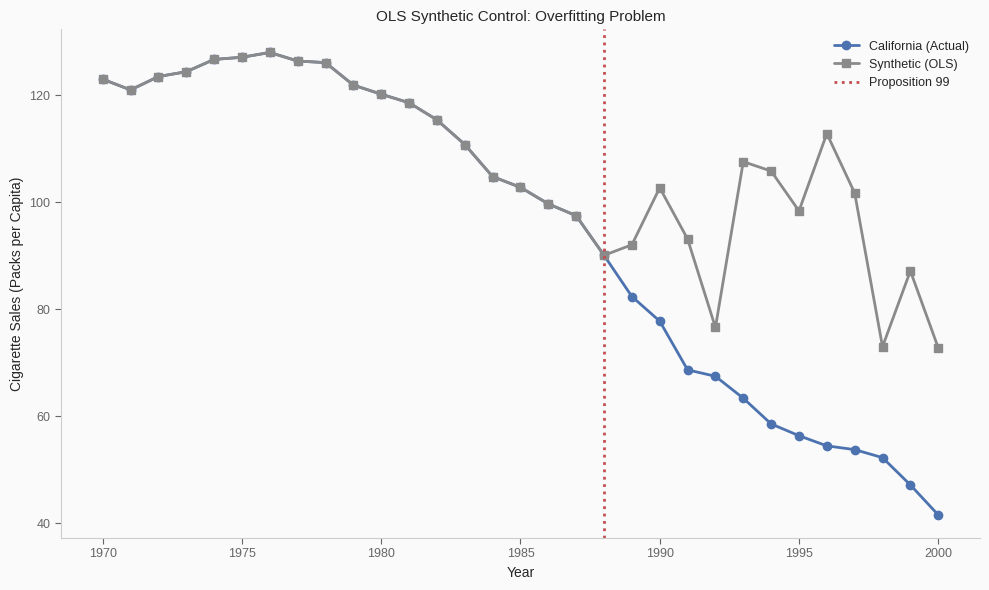


⚠️ OLS fits pre-treatment perfectly but post-treatment is erratic!
   This is classic overfitting.


In [4]:
# Build synthetic California with OLS weights
calif_synth_ols = (cigar.query('~california')
                   .pivot(index='year', columns='state')['cigsale']
                   .values.dot(weights_ols))

calif_actual = cigar.query('california').sort_values('year')['cigsale'].values
years = cigar.query('california').sort_values('year')['year'].values

# Plot
fig, ax = create_tufte_figure(figsize=(10, 6))

ax.plot(years, calif_actual, 'o-', color=TUFTE_PALETTE['treatment'], 
        linewidth=2, markersize=6, label='California (Actual)')
ax.plot(years, calif_synth_ols, 's-', color=TUFTE_PALETTE['control'], 
        linewidth=2, markersize=6, label='Synthetic (OLS)')
ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2, label='Proposition 99')

ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales (Packs per Capita)')
ax.set_title('OLS Synthetic Control: Overfitting Problem')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("\n⚠️ OLS fits pre-treatment perfectly but post-treatment is erratic!")
print("   This is classic overfitting.")

### 3.2 Constrained Optimization

In [5]:
# Define loss function
def loss_w(W, X, y):
    """Root mean squared error between synthetic and treated."""
    return np.sqrt(np.mean((y - X.dot(W))**2))

# Constrained optimization
def get_weights(X, y):
    """Find weights minimizing pre-treatment RMSE with convex constraints."""
    n_units = X.shape[1]
    w_start = [1/n_units] * n_units  # Start with equal weights
    
    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        np.array(w_start),
        f_eqcons=lambda x: np.sum(x) - 1,  # Sum to 1
        bounds=[(0.0, 1.0)] * n_units,      # Non-negative
        disp=False
    )
    return weights

# Get constrained weights
weights_constrained = get_weights(X, y)

print("CONSTRAINED WEIGHTS:")
print("=" * 60)
print(f"Sum of weights: {weights_constrained.sum():.6f}")
print(f"Min weight: {weights_constrained.min():.6f}")
print(f"Max weight: {weights_constrained.max():.6f}")
print(f"Non-zero weights: {(weights_constrained > 0.01).sum()}")
print(f"\n✓ Weights are sparse and interpretable!")

CONSTRAINED WEIGHTS:
Sum of weights: 1.000000
Min weight: 0.000000
Max weight: 0.456622
Non-zero weights: 5

✓ Weights are sparse and interpretable!


In [6]:
# Show which states contribute
state_ids = cigar.query('~california')['state'].unique()
weight_df = pd.DataFrame({'state': state_ids, 'weight': weights_constrained})
weight_df = weight_df[weight_df['weight'] > 0.01].sort_values('weight', ascending=False)

print("\nSTATES CONTRIBUTING TO SYNTHETIC CALIFORNIA:")
print("-" * 40)
for _, row in weight_df.iterrows():
    print(f"  State {int(row['state']):2d}: {row['weight']:.1%}")
print("-" * 40)
print(f"  Total: {weight_df['weight'].sum():.1%}")


STATES CONTRIBUTING TO SYNTHETIC CALIFORNIA:
----------------------------------------
  State 23: 45.7%
  State 34: 24.0%
  State 21: 11.3%
  State 22: 10.5%
  State  5: 8.5%
----------------------------------------
  Total: 100.0%


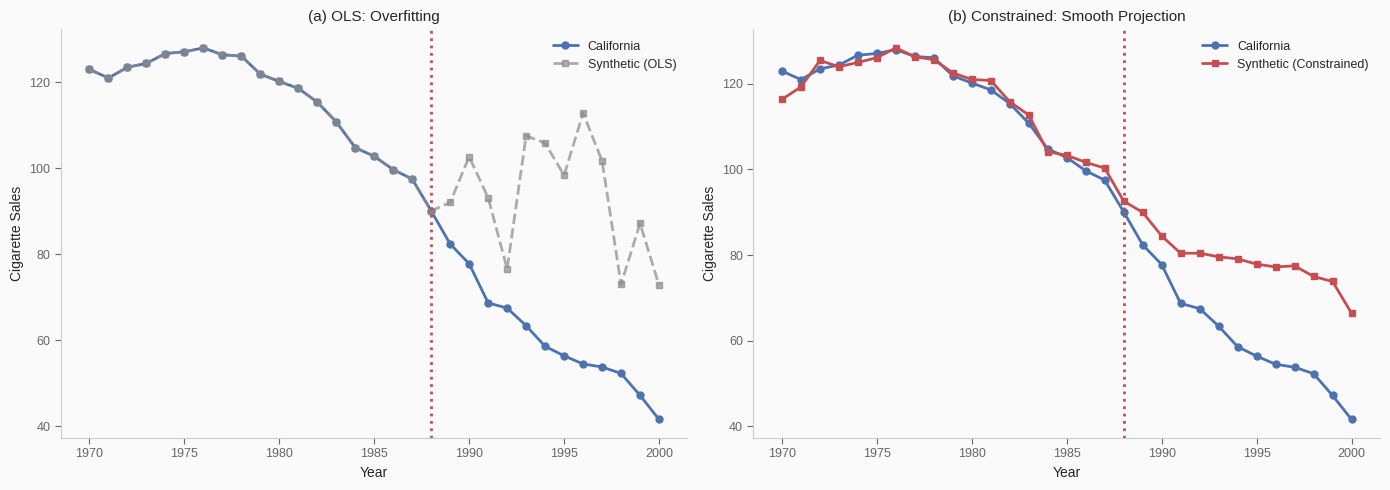

In [7]:
# Build synthetic California with constrained weights
calif_synth_constrained = (cigar.query('~california')
                           .pivot(index='year', columns='state')['cigsale']
                           .values.dot(weights_constrained))

# Compare OLS vs Constrained
fig, axes = create_tufte_figure(1, 2, figsize=(14, 5))

# Panel 1: OLS
ax = axes[0]
ax.plot(years, calif_actual, 'o-', color=TUFTE_PALETTE['treatment'], 
        linewidth=2, markersize=5, label='California')
ax.plot(years, calif_synth_ols, 's--', color=TUFTE_PALETTE['secondary'], 
        linewidth=2, markersize=5, alpha=0.7, label='Synthetic (OLS)')
ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2)
ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales')
ax.set_title('(a) OLS: Overfitting')
ax.legend(frameon=False)

# Panel 2: Constrained
ax = axes[1]
ax.plot(years, calif_actual, 'o-', color=TUFTE_PALETTE['treatment'], 
        linewidth=2, markersize=5, label='California')
ax.plot(years, calif_synth_constrained, 's-', color=TUFTE_PALETTE['effect'], 
        linewidth=2, markersize=5, label='Synthetic (Constrained)')
ax.axvline(1988, color=TUFTE_PALETTE['effect'], linestyle=':', linewidth=2)
ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales')
ax.set_title('(b) Constrained: Smooth Projection')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [8]:
# Quantify the difference
pre_mask = years < 1988
post_mask = years >= 1988

rmse_ols_pre = np.sqrt(np.mean((calif_actual[pre_mask] - calif_synth_ols[pre_mask])**2))
rmse_ols_post = np.sqrt(np.mean((calif_actual[post_mask] - calif_synth_ols[post_mask])**2))
rmse_constr_pre = np.sqrt(np.mean((calif_actual[pre_mask] - calif_synth_constrained[pre_mask])**2))
rmse_constr_post = np.sqrt(np.mean((calif_actual[post_mask] - calif_synth_constrained[post_mask])**2))

print("\nFIT QUALITY COMPARISON:")
print("=" * 50)
print(f"{'Method':<20} {'Pre-RMSE':>12} {'Post-RMSE':>12}")
print("-" * 50)
print(f"{'OLS (unconstrained)':<20} {rmse_ols_pre:>12.2f} {rmse_ols_post:>12.2f}")
print(f"{'Constrained':<20} {rmse_constr_pre:>12.2f} {rmse_constr_post:>12.2f}")
print("\nNote: OLS has perfect pre-fit but erratic post-fit")
print("      Constrained trades some pre-fit for stable projection")


FIT QUALITY COMPARISON:
Method                   Pre-RMSE    Post-RMSE
--------------------------------------------------
OLS (unconstrained)          0.00        35.14
Constrained                  2.07        18.56

Note: OLS has perfect pre-fit but erratic post-fit
      Constrained trades some pre-fit for stable projection


★ Insight ─────────────────────────────────────
**Constrained optimization:**

- Prevents overfitting by limiting to convex combinations
- Produces sparse, interpretable weights
- Small pre-treatment error traded for stable post-treatment projection
- This is the core of the synthetic control method
─────────────────────────────────────────────────

---

## 4. Implementation

**Production code**:

```python
from scipy.optimize import fmin_slsqp
from functools import partial

def loss_w(W, X, y):
    """RMSE loss for synthetic control."""
    return np.sqrt(np.mean((y - X.dot(W))**2))

def get_synthetic_weights(X, y):
    """
    Find optimal synthetic control weights.
    
    Parameters
    ----------
    X : array (T_pre, J)
        Pre-treatment outcomes for J control units
    y : array (T_pre,)
        Pre-treatment outcomes for treated unit
        
    Returns
    -------
    weights : array (J,)
        Non-negative weights summing to 1
    """
    J = X.shape[1]
    w_init = np.ones(J) / J  # Equal weights start
    
    weights = fmin_slsqp(
        partial(loss_w, X=X, y=y),
        w_init,
        f_eqcons=lambda w: np.sum(w) - 1,
        bounds=[(0, 1)] * J,
        disp=False
    )
    return weights
```

**Alternative: CVXPY** for more complex constraints:

```python
import cvxpy as cp

W = cp.Variable(J, nonneg=True)
objective = cp.Minimize(cp.sum_squares(y - X @ W))
constraints = [cp.sum(W) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()
weights = W.value
```

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Why do we use constrained optimization instead of just OLS?"*

<details>
<summary>Solution</summary>

**OLS problems in synthetic control**:

1. **Overfitting**: With J controls and T<J time periods, OLS has more parameters than observations
   - Perfect pre-treatment fit
   - Erratic, unreliable post-treatment projection

2. **Extrapolation**: OLS allows negative and unbounded weights
   - "Subtract 50% of Texas" is meaningless
   - Extrapolates beyond observed data

3. **Interpretability**: OLS weights are hard to explain
   - What does w = -1.2 mean?

**Constrained optimization fixes these**:

1. **Regularization**: Constraints limit degrees of freedom → less overfitting
2. **Interpolation**: Convex combination stays within the data range
3. **Interpretability**: "30% Nevada + 25% Utah" is meaningful

**Key insight**: The constraints act like regularization (similar to Lasso), encouraging sparse, stable solutions.

</details>

---

**Q2 (Google L5, Quant)**: *"How do you choose the importance weights $v_h$ for different features?"*

<details>
<summary>Solution</summary>

**Three approaches**:

1. **Equal weights** (simple):
   - $v_h = 1$ for all features
   - Requires feature standardization first
   - Most common in practice

2. **Inverse variance** (automatic):
   - $v_h = 1/\text{Var}(X_h)$
   - Features with high variance get less weight
   - Similar to standardization

3. **Cross-validated** (optimal):
   - Choose $V$ to minimize out-of-sample prediction error
   - Nest optimization: outer loop over $V$, inner loop over $W$
   - Computationally expensive but more principled

**Practical advice**:
- Start with equal weights on standardized features
- If outcome prediction is key, give lagged outcomes higher weight
- Cross-validation is gold standard but often not worth the complexity

</details>

---

**Q3 (Amazon L6, Econ)**: *"What happens if the treated unit is outside the convex hull of control units?"*

<details>
<summary>Solution</summary>

**Outside the hull = can't be perfectly matched**.

**Example**: California has the lowest cigarette sales AND highest prices. No positive combination of other states can match both.

**Consequences**:

1. **Non-zero pre-treatment error**: Some mismatch is unavoidable
2. **Extrapolation risk**: The counterfactual is partly "made up"
3. **Bias potential**: Treatment effect may be biased

**What to do**:

1. **Report pre-treatment fit**: Be transparent about the mismatch
2. **Sensitivity analysis**: Show results under different weight specifications
3. **Covariate adjustment**: Augmented SCM adds regression adjustment
4. **Consider**: Maybe SCM isn't appropriate for this case

**Key interview point**: Being outside the hull is informative—it tells us the treated unit is "extreme" in ways the controls can't capture.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 15: "Synthetic Control."

[^2]: Abadie, A., Diamond, A., and Hainmueller, J. (2010). Synthetic Control Methods for Comparative Case Studies. *JASA*, 105(490), 493-505.

[^3]: Abadie, A. and Gardeazabal, J. (2003). The Economic Costs of Conflict: A Case Study of the Basque Country. *American Economic Review*, 93(1), 113-132.

[^4]: Doudchenko, N. and Imbens, G. W. (2016). Balancing, Regression, Difference-In-Differences and Synthetic Control Methods: A Synthesis. NBER Working Paper No. 22791.

---

**Precision Improvement:**
- You said: "Build optimization notebook"
- Concise: "Build 02_optimization.ipynb"
- Precise: `/augmented 15.2 --fmin-slsqp --convex-constraints`
- Pattern: [build] [target] [content-flags]